# Preparing for Machine Learning

In [ ]:
import pyodbc

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=GOOSEBOX;"
    "DATABASE=NFL;"
    "Trusted_Connection=yes;"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)
print("Connection successful!")
conn.close()


In [ ]:
from sqlalchemy import create_engine
import urllib

# Define the connection parameters
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=GOOSEBOX;"
    "DATABASE=NFL;"
    "Trusted_Connection=yes;"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)

# Create the SQLAlchemy engine
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# Test the connection
try:
    with engine.connect() as connection:
        print("SQLAlchemy connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")


Note: Polars cannot read directly from a SQL Database, but since the data has been shrunk at this point, we can continue the 
analysis in Pandas, rather than converting from pandas to polars and back to pandas again in creating new ML databases. 

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import urllib

# Define your SQL query
query = "SELECT * FROM dbo.Injury_Summary"

# Use Pandas to read the SQL query into a DataFrame
with engine.connect() as connection:
    pandas_df = pd.read_sql_query(query, connection)

In [1]:
path = "F:/Data/Processing_data/"
file1 = "All_Tracking.parquet"
file2 = "Full_Summary_Concussions.parquet"
file3 = "Full_Summary_Injuries.parquet"

In [27]:
import os
import polars as pl

df = pl.read_parquet(os.path.join(path, file3))

In [28]:
df.head()

PlayKey,Position,StadiumType,FieldType,Temperature,Weather,PlayType,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,IsInjured,IsSevere,Position_right,Distance,Displacement,Path_Diff,Max_Angle_Diff,Mean_Angle_Diff,Max_Speed,Mean_Speed,Max_Impulse,Mean_Impulse,Max_Torque,Mean_Torque,Max_Int_Torque,Mean_Int_Torque
str,cat,cat,cat,i16,cat,cat,cat,i8,i8,i8,i8,i8,i8,cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""26624-1-20""","""QB""","""Outdoor""","""Synthetic""",63,"""Clear""","""Rush""","""No_Injury""",0,0,0,0,0,0,"""QB""",12.560955,5.40202,7.158936,178.440002,78.945656,3.712159,0.483114,187.427231,13.7315,38.490417,-0.010563,72.574364,-0.004217
"""26624-1-22""","""QB""","""Outdoor""","""Synthetic""",63,"""Clear""","""Pass""","""No_Injury""",0,0,0,0,0,0,"""QB""",27.687366,7.580832,20.106533,179.25,101.294319,4.517752,1.936179,72.198616,17.693897,195.079529,0.01526,136.597397,-0.015356
"""26624-1-23""","""QB""","""Outdoor""","""Synthetic""",63,"""Clear""","""Rush""","""No_Injury""",0,0,0,0,0,0,"""QB""",28.736702,8.434956,20.301746,178.229996,78.788918,4.414752,1.037426,240.314255,15.576145,197.972412,0.05488,135.239807,-0.031697
"""26624-1-24""","""QB""","""Outdoor""","""Synthetic""",63,"""Clear""","""Unknown""","""No_Injury""",0,0,0,0,0,0,"""QB""",25.678587,3.967429,21.711157,178.919998,89.392487,4.60975,0.850284,94.129692,14.66524,196.742706,0.067654,136.555679,-0.02783
"""26624-1-45""","""QB""","""Outdoor""","""Synthetic""",63,"""Clear""","""Pass""","""No_Injury""",0,0,0,0,0,0,"""QB""",24.427948,10.659006,13.768942,179.690002,94.147797,4.019967,0.592911,240.312332,11.786748,195.729614,0.003361,135.342194,-0.00585


Since casting is remaining an issue with pulling from the database, I'm going to continue to work with the local files for the machine learning. I can still use the tracking data from the database for the work in PowerBI. 

## Conversions for Machine Learning

To Encode the Categoricals, I can use OneHotEncoder to change each of the categories into a column using binary values. Increasing the dimensionality 
isn't ideal, but with the datasize as Int8 for each new column will keep the size down. 

Categoricals: 
- Position
- StadiumType
- FieldType
- Weather
- PlayType
- BodyPart


Numerical Values will need to be normalized between 0 and 1. I'll have to figure out how to best do this with the negative values, which represent directionality. 

Numericals: 
- Temperature
- Distance
- Displacement
- Path_Diff
- Max_Angle_Diff
- Mean_Angle_Diff
- Max_Speed
- Mean_Speed
- Max_Impulse 
- Mean_Impulse
- Max_Torque
- Mean_Torque
- Max_Int_Torque
- Mean_Int_Torque


Encoded: 
- IsInjured (There is an injury present)
- IsSevere (The injury resulted in longer than 4 weeks missed)


Drop Columns: 
- DM_M1
- DM_M7
- DM_M28
- DM_M42
- Position_right

In [29]:
Position_Counts = df["Position"].n_unique()
StadiumType_Counts = df["StadiumType"].n_unique()
FieldType_Counts = df["FieldType"].n_unique()
Weather_Counts = df["Weather"].n_unique()
PlayType_Counts = df["PlayType"].n_unique()
BodyPart_Counts = df["BodyPart"].n_unique()

print(f"There are {Position_Counts} unique positions, \n{StadiumType_Counts} unique stadium types, \n{FieldType_Counts} unique field types, \n{Weather_Counts} classifications of weather, \n{PlayType_Counts} unique play types, and \n{BodyPart_Counts} body parts injured in this analysis.")


There are 22 unique positions, 
2 unique stadium types, 
2 unique field types, 
7 classifications of weather, 
7 unique play types, and 
4 body parts injured in this analysis.


In [30]:
unique_play_types = df["PlayType"].unique().sort(descending=False)
for play_type in unique_play_types:
    print(play_type)

Pass
Rush
Unknown
Kickoff
Field Goal
Punt
Extra Point


In [31]:
import polars as pl
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

path = "F:/Data/Processing_data/"
file2 = "Full_Summary_Concussions.parquet"
file3 = "Full_Summary_Injuries.parquet"

df = pl.read_parquet(os.path.join(path, file3))

In [32]:
# Count occurrences of each PlayKey
playkey_counts = df["PlayKey"].value_counts()

playkey_counts.filter(pl.col("count")>1)

PlayKey,count
str,u32
"""47307-10-18""",2


There is only one duplicate PlayKey, and it is because that player injured 2 different bodyparts in the same play.

In [33]:
df["IsInjured"].value_counts()

IsInjured,count
i8,u32
0,266517
1,77


In [34]:
df = df.drop(['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'Position_right'])

# Predicting if IsInjured or if the injury IsSevere

The target features will be IsInjured and IsSevere. 
I'm dealing with a very imbalanced Dataset, so I will be using Gradient Boosting, XGBoost for classification. I need to keep the datasets stratified and weight the data to maintain the stratification. 

The AUC evaluation metric is the Area Under Curve of the ROC curve, or Receiver Operating Characteristic. The ROC curve plots the true positivive rate (Sensivitity) as a function of the false positive rate (100-Specificity) for different cutoff points of a parameter. The AUC ROC is a measure of how well a parameter can distinguish between two diagnostic groups. 

In [79]:
# Establish Supervised Learning Sets
X = df.drop(['IsInjured'
            , 'IsSevere'
            , 'BodyPart'
            , 'PlayKey'
            , 'Position'
            , 'Temperature'
            , 'StadiumType'
            , 'FieldType'
            , 'Weather'
            , 'Distance'
            , 'Displacement'
            # , 'Path_Diff'
            # , 'Max_Angle_Diff'
            # , 'Mean_Angle_Diff'
            # , 'Max_Speed'
            # , 'Mean_Speed'
            # , 'Max_Impulse'
            # , 'Mean_Impulse'
            # , 'Max_Torque'
            # , 'Mean_Torque'
            # , 'Max_Int_Torque'
            # , 'Mean_Int_Torque'
            ])  
y = df['IsInjured']

In [80]:
# Define features that need encoding and scaling
# categorical_features = ['StadiumType'
#                         , 'FieldType'
#                         , 'Weather'
#                         , 'PlayType']
numerical_features = [
                    # 'Temperature'
                    #   , 'Distance'
                    #   , 'Displacement'
                       'Path_Diff'
                      , 'Max_Angle_Diff'
                      , 'Mean_Angle_Diff'
                      , 'Max_Speed'
                      , 'Mean_Speed'
                      , 'Max_Impulse'
                      , 'Mean_Impulse'
                      , 'Max_Torque'
                      , 'Mean_Torque'
                      , 'Max_Int_Torque'
                      , 'Mean_Int_Torque']

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
        # , ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [82]:
from xgboost import XGBClassifier

# Calculate the scale_pos_weight
scale_pos_weight = df.filter(pl.col("IsInjured") == 0).shape[0] / df.filter(pl.col("IsInjured") == 1).shape[0]

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight
    , eval_metric='auc'
    , max_depth=3
    , learning_rate=0.1
    , n_estimators=100
    , subsample=0.8
    , colsample_bytree=0.8
)

# Create the full pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=94)

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Path_Diff',
                                                   'Max_Angle_Diff',
                                                   'Mean_Angle_Diff',
                                                   'Max_Speed', 'Mean_Speed',
                                                   'Max_Impulse',
                                                   'Mean_Impulse', 'Max_Torque',
                                                   'Mean_Torque',
                                                   'Max_Int_Torque',
                                                   'Mean_Int_Torque'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=Non...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [85]:
feature_importance = full_pipeline.named_steps['classifier'].feature_importances_

# Get feature names for categorical features
# cat_feature_names = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()

# Combine categorical and numerical feature names
feature_names = numerical_features

for feature, importance in sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")

Mean_Impulse: 0.11727102845907211
Max_Speed: 0.11345569789409637
Max_Int_Torque: 0.09776671975851059
Mean_Torque: 0.09196730703115463
Max_Impulse: 0.09051451832056046
Path_Diff: 0.08673316240310669
Mean_Int_Torque: 0.08662059903144836
Mean_Speed: 0.08557642251253128
Max_Angle_Diff: 0.08364870399236679
Max_Torque: 0.0790976956486702
Mean_Angle_Diff: 0.06734819710254669


In [86]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(full_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC-ROC scores: {cv_scores}")
print(f"Mean AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation AUC-ROC scores: [0.73587473 0.81541348 0.64160085 0.73958431 0.57409527]
Mean AUC-ROC: 0.7013 (+/- 0.1684)


In [87]:
from sklearn.metrics import average_precision_score, precision_recall_curve

y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score: {avg_precision:.4f}")

Average Precision Score: 0.0011


In [88]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = full_pipeline.predict(X_test)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     53304
           1       0.00      0.33      0.00        15

    accuracy                           0.94     53319
   macro avg       0.50      0.64      0.49     53319
weighted avg       1.00      0.94      0.97     53319

AUC-ROC: 0.7298176497073391


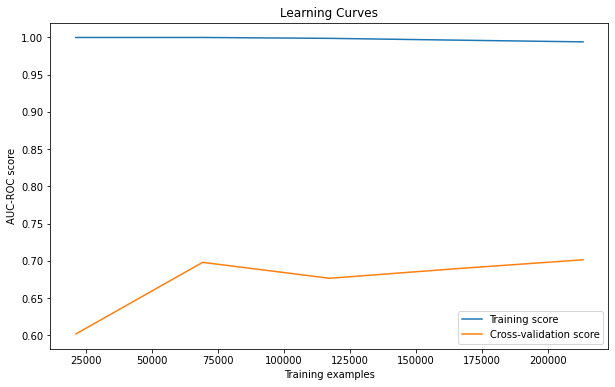

In [89]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    full_pipeline, X, y, cv=5, scoring='roc_auc', 
    train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('AUC-ROC score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [52]:
import sklearn
import xgboost

print(f"scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")


scikit-learn version: 1.5.1
XGBoost version: 2.1.1
